In [1]:
import sys
import torch
import algos
import numpy as np
import math
import numpy.random as random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Closed form solution: beta = np.linalg.inv(X.T @ X) @ X.T @ y

Consider the scenario where:
- $x$ ~ $N(0, I_{dxd})$
- $y|x$ ~ $N(\langle x,\beta \rangle, \sigma^2)$
- We know $\frac{1}{n}X^TX = I_{dxd}$
- Need to estimate $ \frac{1}{n}X^Ty \approx E(x * \langle x, \beta \rangle) $
- Use CoinPress with input $z_i = x_iy_i$


But another thing we need to consider is that CoinPress assumes covariance matrix of z is $I_{dxd}$
- Can we assume this? No...
- Therefore we must normalize the $z_i$'s that we pass to CoinPress
- We have calculated the diagonals of $cov(Z)$ are $\beta_j^2  + ||\beta||_2^2 + 1$ 
- Since as of right now, $\beta$ ~ $N(0,1)$, $\beta_j^2 = 1$, $||\beta||_2^2 = d$, so each diagonal entry is approx $d+2$
- Therefore, if the diagonals are >> the non-diagonals, we can assume that $\frac{z}{\sqrt{d}}$ ~ $N(C, I_{dxd})$


Dimmension / understanding check:
- $x$: $nxd$
- $y$: $nx1$
- $\beta$: $dx1$ 
- $z$: $nxd$ => then want to find mean of this to approx beta!

In [2]:
def generate_data(n,d):
    
    """Creates an nxd matrix X, a 1xd underlying_dist vector, nx1 y vector, and nxd z vector (where zi=xi*yi)"""
    
    # generate an n x d data matrix with N(0,1) entries- feature matrix
    X = random.normal(0,1.0,(n,d))
    X = np.array(X)
    
    # underlying distribution (beta hat)
    underlying_dist = random.normal(0,1.0,(1,d))
    underlying_dist = np.array(underlying_dist)
    
    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + random.normal(0,1))
    y = np.array(y)  
    
    # Generate z = xy
    z = []
    for i in range(n):
        z.append(X[i] * y[i])
    z = np.array(z)
    
    return X,y,z,underlying_dist


# n=10000
# d=5
# X,y,z,underlying_dist = generate_data(n,d)

In [3]:
def covariance_matrix(z):
    z = z - underlying_dist
    return (z.T@z)/n  # z.t@z grows w n

# df = pd.DataFrame(covariance_matrix(z))
# df

In [4]:
def predicted_covariance():
    predicted_cov = np.zeros((d,d))
    for row in range(d):
        for col in range(d):
            if row == col:
                predicted_cov[row][col] = underlying_dist[0][row]**2 + np.linalg.norm(underlying_dist[0]) ** 2 + 1 
            else:
                predicted_cov[row][col] = underlying_dist[0][row]*underlying_dist[0][col]
                
    return predicted_cov

# df = pd.DataFrame(predicted_covariance())
# df

At this point, it does not look like the covariance matrix is dominated by it's diagonal entries
This means:
- I should calculate out what the non-diagonal entries actually are
    - At an initial calculation, non-diagonal entries ($Cov(z_j,z_k)$ where $z_j \neq z_k$) appear to take on value: $\beta_j \beta_k$
- I cannot just depend on multiplying each $z$ by $\frac{1}{\sqrt{d}}$, need to renormalize by predicted $\Sigma$? 

$T(z, \hat\mu) = \left\langle \Sigma^{-1/2} (z - \mu), \Sigma^{-1/2}(\hat\mu - \mu) \right\rangle$ 


In [5]:
def coinpress_linreg_mean(z, c, r, d, beta_norm_sqr=None, t=2, total_budget=0.5):
    if beta_norm_sqr is None: 
        beta_norm_sqr = d
    z = z/np.sqrt(2*beta_norm_sqr+1)
    rho = [(1.0/4.0)*total_budget, (3.0/4.0)*total_budget]
    return algos.multivariate_mean_iterative(z, c, r, t, rho)*np.sqrt(2*beta_norm_sqr+1)

In [6]:
def error(z,c,r,d,iters):
    errors = []
    for i in range(iters):
        error = np.linalg.norm(np.mean(z, axis=0) - coinpress_linreg_mean(z, c, r, d))
        errors.append(error)
        
    return errors

To analyze how well this algorithm works, we can find it's excess loss:
$$\mathbb{E}[(\langle x, \hat{\beta} \rangle - y)^2 - (\langle x, \beta \rangle - y)^2]$$
Because what we really care about is how well our estimate for $\hat{\beta}$ predicts the true values.

In [7]:
def excess_loss(beta_hat, beta, d):
    """ generate n d-dimensional x values and y values to test excess loss of our predicted beta_hat vs. underlying distribution beta """
    
    n = 1000
    x = random.normal(0,1.0,(n,d))
    x = np.array(x)
    y = []
    
    for i in range(n):
        y.append(np.dot(beta, x[i]) + random.normal(0,1))
    y = np.array(y)  
    
    sum_losses = 0
    n = len(x)
    for i in range(n):
        predicted_dist = (x[i] @ beta_hat - y[i])**2
        actual_dist = (x[i] @ beta - y[i])**2 # if this = 1, it's essentially the same thing as n -> \inf
        loss = predicted_dist - actual_dist
        sum_losses += loss
    return sum_losses / n

In [27]:
excess_loss([1,2,3],[1,1,1],1)

ValueError: shapes (3,) and (1,) not aligned: 3 (dim 0) != 1 (dim 0)

In [12]:
def nonprivate_linreg_mean(x, y):
    """ find beta_hat from distribution """
    
    # Create linear regression object
    regr = linear_model.LinearRegression()

    n = len(y)
    # Train the model using the training sets
#     regr.fit(x, y)
#     return (x.T @ y) / n
    return np.linalg.inv(x.T @ x) @ x.T @ y
#     return (1/n) * (x.T @ y)

#     return regr.coef_

Compare to: what if we did not add privacy - default solution to lin reg.
- given data, what is solution, compare excess loss (use scipy linreg / closed form)
- get a sense of what is a 'normal' excess risk
- still wouldn't be zero, would help to have a sense of checking our baseline
- As n goes to infinity, should have excess risk going to 0.
- saw comparing it to CoinPress high total_budget doesn't make too significant a diff

If we evaluate on new data, optimal soln is underlying_dist, expected loss of optimal soln 1
- better to evaluate on a new dataset (generate x same way, y using underlying_dist) !!!
- in expectation, actual loss is 1


Messing around with other underlying distributions ($\beta$)
- Nothing about our assumptions relies on $\beta$ ~ $N(0,1)$
- Will first try out running experiment with $N(\mu, \sigma^2)$, varying $\mu$ and $\sigma$
- Then, we will need to rescale each $z_i$ by $2 \|\beta\|^{2}_2 + 1$
- Moving forward, will need to estimate $\|\beta\|^{2}_2$

In [9]:
def generate_data_beta_normal(n,d,beta_mean,beta_var):
    
    """Creates an nxd matrix X, a 1xd underlying_dist vector, nx1 y vector, and nxd z vector (where zi=xi*yi)"""
    
    # generate an n x d data matrix with N(0,1) entries- feature matrix
    X = random.normal(0,1.0,(n,d))
    X = np.array(X)
    
    # underlying distribution (beta hat)
    underlying_dist = random.normal(beta_mean,beta_var,(1,d))
    underlying_dist = np.array(underlying_dist)
    
    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + random.normal(0,1))
    y = np.array(y)  
    
    # Generate z = xy
    z = []
    for i in range(n):
        z.append(X[i] * y[i])
    z = np.array(z)
    
    return X,y,z,underlying_dist

In [28]:
def run_experiment_beta_normal(d, beta_mean=0, beta_var=1, iters=30):
#     n_values = [2000]
    n_values = [2000, 4000, 6000, 8000, 10000]
#     n_values = [100, 500, 1000, 5000]
    c = [0]*d
#     r = 10*np.sqrt(d)
    r = 100*np.sqrt(d)
    
    # want to keep track and plot coinpress vs. non-private excess loss
    losses = []
    nonpriv_losses = []
    dists = []

    for n in n_values:
        """ for all n values, take the average of the loss after running the trial t times"""
        curr_losses = []
        curr_dist = []
        curr_nonpriv_losses = []
        for i in range(iters):
            # generated data = nxd matrix x, nx1 vector y, nxd matrix z
            # TODO: eventually change how to find beta_norm
            x,y,z,underlying_dist = generate_data_beta_normal(n,d,beta_mean,beta_var)
            beta_norm = np.linalg.norm(underlying_dist) ** 2
            
            # generate b_hat, and it's nonprivate counterpart by using coinpress and general linreg respectively
            b_hat = coinpress_linreg_mean(z, c, r, d, beta_norm, total_budget=0.5)@np.linalg.inv((1/n) * (x.T @ x))
            nonpriv_b_hat = nonprivate_linreg_mean(x,y)

            dist = np.linalg.norm(b_hat - nonpriv_b_hat)

            # find excess loss of b_hat and nonprivate b_hat
            loss = excess_loss(b_hat, underlying_dist[0], d)
            nonpriv_loss = excess_loss(nonpriv_b_hat, underlying_dist[0], d)
            curr_nonpriv_losses.append(nonpriv_loss)
            curr_losses.append(loss)
            curr_dist.append(dist)
        losses.append(np.mean(np.array(curr_losses)))
        dists.append(np.mean(np.array(curr_dist)))
        nonpriv_losses.append(np.mean(np.array(curr_nonpriv_losses)))

    print(f"losses: {losses}")
    print(f"non-private losses: {nonpriv_losses}")
    print(f"distances: {dists}")
    plt.plot(n_values, losses, 'bo-')
    plt.plot(n_values, nonpriv_losses, 'rx--')
#     plt.plot(n_values, dists, 'rx--')

losses: [2.613974663299869, 0.35155383270696766, 0.17982300586584427, 0.12216089674634653, 0.12449420734859011]
non-private losses: [0.02687743426703001, 0.012609836134352652, 0.008852194079914642, 0.0053410283121607715, 0.003906720893198528]
distances: [1.6231221684413992, 0.5743072090869309, 0.40100091522272874, 0.34536415987132596, 0.34930537709228454]


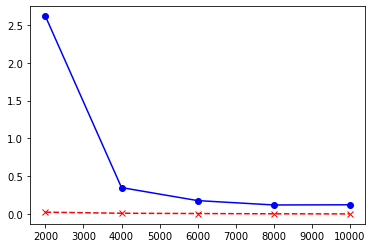

In [26]:
run_experiment_beta_normal(50)

Findings from experimentation with clipping threshold w high total privacy budget
- not clipping the ball makes the two curves nearly identical (private slightly worse becasue adding some noise)
- for all of the following generated images of graphs to get a rough idea, using d=50, iters=30, total_budget=100, n=[2000,4000,6000,8000,10000]

- clip_thresh * 2:
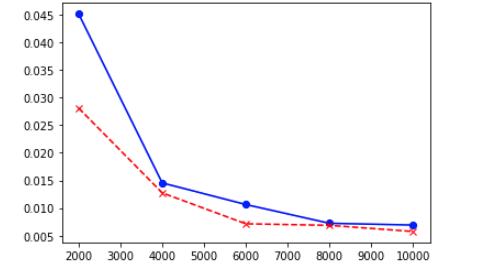

- clip_thresh * 1.5:
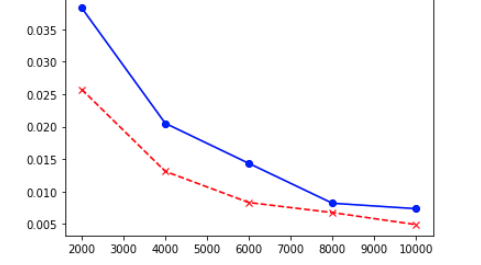

- clip_thresh * 1.25:
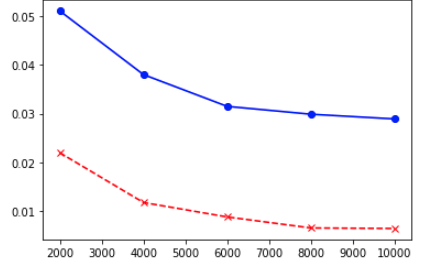

- clip_thresh * 1.1:
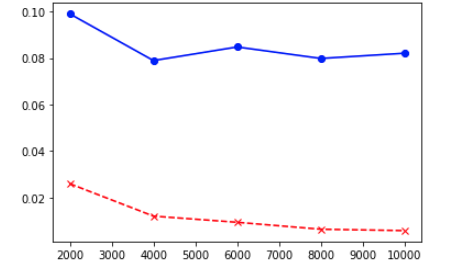

- normal clip_thresh:
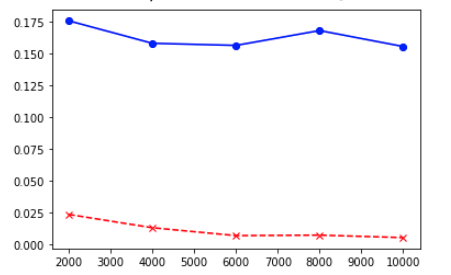

Findings from experimentation with clipping threshold w high total privacy budget

-not clipping the ball makes the two curves nearly identical (private slightly worse becasue adding some noise)

-for all of the following generated images of graphs to get a rough idea, using d=50, iters=30, total_budget=0.5, n=[2000,4000,6000,8000,10000]

- clip_thresh*2:
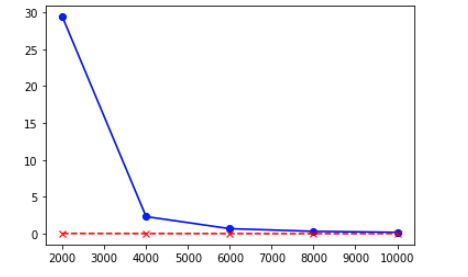

- clip_thresh*1.5:
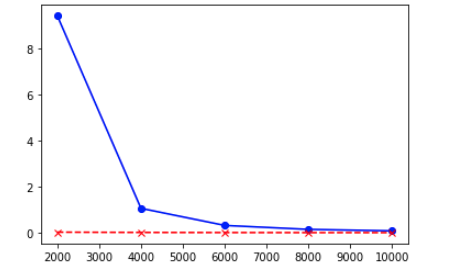

- clip_thresh*1.25:
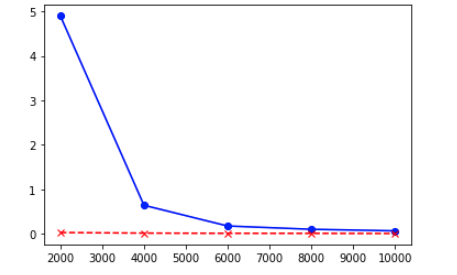

- clip_thresh*1.1:
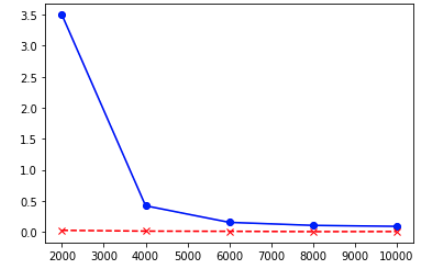

- normal clip_thresh: 
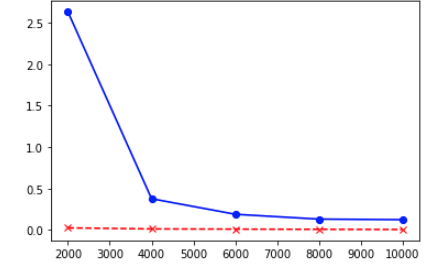

- clip_thresh*0.5:
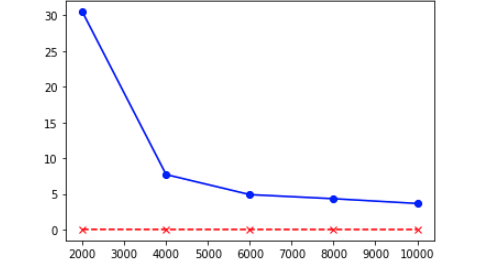


- With a lower privacy budget, having a larget clipping threshold seems to make the error explode with smaller n

Maybe look at d=10 or d=5, will need this for covariance step 

Possible that things that are relatively close together in l2 norm give very diff excess loss,
- plot diff in norm between closed form soln and coinpress version
    - excess loss is a little more task oriented
- in ML world, you usually think of LR as an algo for making predictions, and want to see how well it predicts
- when our covariance matrix is identity, our algorithm will recover exact beta
- error better by making privacy budget larger
    - chose 0.5 because it's nearly equivalent to $\epsilon=1$
    - if you do lots of iterations, but keep final step smallest, but in the last stage you do what you would've done in the first place